# Forecasting dengan Auto Corelation

## - Apa itu Forecasting?

Bayangkan Anda adalah seorang kapten kapal yang mencoba menavigasi lautan yang tidak pasti di depan. Untuk tahu ke mana harus berlayar, Anda tidak bisa hanya menebak-nebak; Anda harus melihat ke belakang, mempelajari catatan perjalanan sebelumnya, menganalisis pola angin musiman, dan data arus laut yang telah dikumpulkan. Inilah inti dari forecasting (peramalan): sebuah proses sistematis untuk memprediksi apa yang akan terjadi di masa depan dengan cara menggali dan menganalisis data historis serta tren masa lalu. Baik itu untuk memperkirakan cuaca besok, penjualan produk bulan depan, atau, seperti dalam kasus Anda, memprediksi tingkat polusi $NO_2$, tujuannya selalu sama—yaitu menggunakan wawasan dari masa lalu untuk mengurangi ketidakpastian dan membantu kita mengambil keputusan yang lebih cerdas dan lebih siap hari ini.

## - Mengapa Forecasting penting?

Pada intinya, kita melihat pola-pola yang terjadi di masa lalu (seperti tren musiman, siklus, atau kebiasaan) dan menggunakan pola tersebut untuk membuat perkiraan yang logis tentang apa yang akan terjadi selanjutnya.Tujuan utamanya adalah untuk mengurangi ketidakpastian dalam pengambilan keputusan. Dengan memiliki perkiraan yang berbasis data, sebuah organisasi atau individu dapat membuat perencanaan yang lebih matang, mengantisipasi risiko, dan mengalokasikan sumber daya secara lebih efisien.

## - Crawling Data

### 1. Import libarary yang dibutuhkan

In [1]:
import openeo
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import xarray as xr
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()
print("Connected to Copernicus Data Space Ecosystem")

Authenticated using refresh token.
Connected to Copernicus Data Space Ecosystem


### 2. Definisi kan koordinat di wilayah Kamal dan parameter waktu (2022-2025)

In [3]:
aoi = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              112.71199080623381,
              -7.151070739706199
            ],
            [
              112.71199080623381,
              -7.168985131602568
            ],
            [
              112.73980259222657,
              -7.168985131602568
            ],
            [
              112.73980259222657,
              -7.151070739706199
            ],
            [
              112.71199080623381,
              -7.151070739706199
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}

# Define spatial extent from AOI coordinates
spatial_extent = {
    "west": 112.71199080623381,
    "south": -7.168985131602568,
    "east": 112.73980259222657,
    "north": -7.151070739706199
}

start_date = "2022-10-23"
end_date = "2025-10-23"

print(f"AOI defined for coordinates: {spatial_extent}")
print(f"Time range: {start_date} to {end_date}")
print("Setup completed successfully")

AOI defined for coordinates: {'west': 112.71199080623381, 'south': -7.168985131602568, 'east': 112.73980259222657, 'north': -7.151070739706199}
Time range: 2022-10-23 to 2025-10-23
Setup completed successfully


### 3. Loading data Sentinel-5P NO2 dan agregasi temporal harian

In [4]:
print("Loading Sentinel-5P NO2 data...")

s5p_no2 = connection.load_collection(
    "SENTINEL_5P_L2",
    temporal_extent=[start_date, end_date],
    spatial_extent=spatial_extent,
    bands=["NO2"],
)

s5p_monthly = s5p_no2.aggregate_temporal_period(
    period="day",
    reducer="mean"
)

print("Data collection and aggregation configured successfully")

Loading Sentinel-5P NO2 data...
Data collection and aggregation configured successfully


### 4. Melakukan eksekusi job batch processing untuk memproses data secara otomatis dan terjadwal, kemudian mengekspor hasilnya ke dalam format file NetCDF

In [5]:
print("Starting data processing job...")

job = s5p_monthly.execute_batch(
    title="NO2 Averages 2021-2025", 
    outputfile="no2_averages_4years.nc"
)


Starting data processing job...
0:00:00 Job 'j-2510230639364548b8a07f95b7356934': send 'start'
0:00:13 Job 'j-2510230639364548b8a07f95b7356934': created (progress 0%)
0:00:18 Job 'j-2510230639364548b8a07f95b7356934': created (progress 0%)
0:00:25 Job 'j-2510230639364548b8a07f95b7356934': created (progress 0%)
0:00:33 Job 'j-2510230639364548b8a07f95b7356934': running (progress N/A)
0:00:43 Job 'j-2510230639364548b8a07f95b7356934': running (progress N/A)
0:00:56 Job 'j-2510230639364548b8a07f95b7356934': running (progress N/A)
0:01:12 Job 'j-2510230639364548b8a07f95b7356934': running (progress N/A)
0:01:31 Job 'j-2510230639364548b8a07f95b7356934': running (progress N/A)
0:01:55 Job 'j-2510230639364548b8a07f95b7356934': running (progress N/A)
0:02:26 Job 'j-2510230639364548b8a07f95b7356934': running (progress N/A)
0:03:03 Job 'j-2510230639364548b8a07f95b7356934': running (progress N/A)
0:03:50 Job 'j-2510230639364548b8a07f95b7356934': running (progress N/A)
0:04:49 Job 'j-2510230639364548b

### 5. Ubah data NetCDF ke CSV agar lebih mudah untuk digunakan

In [3]:
# 1. Buka file .nc Anda
# Ganti 'openEO.nc' jika nama filenya berbeda
ds = xr.open_dataset("C:\\Dokumen\\PSD\\dataset\\openEO.nc")

# 2. Konversi dataset xarray menjadi DataFrame pandas
df = ds.to_dataframe()

# 3. [PENTING] Ratakan Multi-Index
# Data NetCDF biasanya punya banyak index (spt waktu, lat, lon).
# 'reset_index()' akan mengubah semua index itu menjadi kolom biasa.
df_flat = df.reset_index()

# 4. Simpan sebagai file CSV
df_flat.to_csv('hasil_data_no2.csv', index=False)

print("Selesai! File 'hasil_data_no2.csv' telah dibuat.")

Selesai! File 'hasil_data_no2.csv' telah dibuat.


## - Preprocessing

### - Mengurutkan Data berdasarkan tanggal/waktu

Mengurutkan data berdasarkan tanggal/waktu (sortir kronologis) adalah langkah preprocessing yang fundamental, terutama untuk data time-series (data berurutan).

Ini penting karena mengubah data yang acak menjadi sebuah alur cerita yang logis.

Tujuannya adalah untuk memastikan bahwa setiap observasi (baris data) ditempatkan dalam urutan yang benar sesuai kejadiannya. Tanpa pengurutan ini, analisis seperti mencari tren, mengidentifikasi pola musiman, atau melakukan interpolasi (mengisi data hilang) akan menghasilkan kesimpulan yang salah, karena hubungan antar-waktu antar-titik data menjadi rusak.

In [2]:
# 1. Baca file CSV
df = pd.read_csv('hasil_data_no2.csv')

# 2. Ubah kolom 't' menjadi format datetime
df['t'] = pd.to_datetime(df['t'])

# 3. Urutkan DataFrame berdasarkan kolom 't'
df_sorted = df.sort_values(by='t')

# 4. Menampilkan hasil pengirutan
print(df_sorted)

print("Selesai! Data telah diurutkan berdasarkan waktu dan disimpan di 'hasil_data_no2_sorted.csv'")

              t           x         y  crs       NO2
0    2022-10-23  112.739273 -7.151624  b''  0.000030
1    2022-10-24  112.739273 -7.151624  b''       NaN
2    2022-10-25  112.739273 -7.151624  b''  0.000070
3    2022-10-26  112.739273 -7.151624  b''       NaN
4    2022-10-27  112.739273 -7.151624  b''       NaN
...         ...         ...       ...  ...       ...
1085 2025-10-18  112.739273 -7.151624  b''  0.000015
1086 2025-10-19  112.739273 -7.151624  b''  0.000056
1087 2025-10-20  112.739273 -7.151624  b''       NaN
1088 2025-10-21  112.739273 -7.151624  b''       NaN
1089 2025-10-22  112.739273 -7.151624  b''       NaN

[1090 rows x 5 columns]
Selesai! Data telah diurutkan berdasarkan waktu dan disimpan di 'hasil_data_no2_sorted.csv'


### - Mengatasi Missing Value dengan interpolasi

Mengatasi *missing value* (data hilang) dengan **interpolasi** adalah teknik *preprocessing* untuk "menebak" nilai yang hilang secara cerdas.

Cara kerjanya adalah dengan **melihat nilai-nilai tetangga yang diketahui** (misalnya, nilai sebelum dan sesudah data yang hilang) dan menarik garis lurus (atau kurva) di antara keduanya. Nilai yang hilang kemudian diisi dengan titik yang jatuh tepat di atas garis tersebut.

Ini adalah metode yang sangat umum untuk data *time-series* (seperti data cuaca atau polusi) karena metode ini **mempertahankan kelancaran dan tren data** dari waktu ke waktu, alih-alih hanya mengisi dengan nilai rata-rata atau membuang baris data.

In [8]:
df['t'] = pd.to_datetime(df['t'])
df_sorted = df.sort_values(by='t')
df_indexed = df_sorted.set_index('t')
df_indexed['NO2'] = df_indexed['NO2'].interpolate(method='time')
df_interpolated = df_indexed.reset_index()
print(f"Data diinterpolasi. Jumlah baris: {len(df_interpolated)}")

Data diinterpolasi. Jumlah baris: 1090


### - DETEKSI & PENANGANAN OUTLIER

In [9]:
p01 = df_interpolated['NO2'].quantile(0.01)
p99 = df_interpolated['NO2'].quantile(0.99)
# Hitung jumlah outlier yang ditemukan
outliers_low = (df_interpolated['NO2'] < p01).sum()
outliers_high = (df_interpolated['NO2'] > p99).sum()
print(f"Deteksi outlier: {outliers_low} nilai rendah dan {outliers_high} nilai tinggi ditemukan.")
# Ganti outlier dengan nilai persentil (clipping)
df_interpolated['NO2'] = df_interpolated['NO2'].clip(lower=p01, upper=p99)
print("Outlier telah diganti (clipping).")

Deteksi outlier: 11 nilai rendah dan 11 nilai tinggi ditemukan.
Outlier telah diganti (clipping).


### - Normalisasi Data menggunakan zscore dengan standart sklearn

Menggunakan StandardScaler (metode Z-score) dari sklearn adalah teknik preprocessing untuk menstandardisasi fitur data Anda.Tujuannya adalah untuk mengubah skala setiap fitur sehingga memiliki:

1. Rata-rata (mean) 
2. Standar deviasi (standard deviation)

Proses ini menghitung seberapa jauh setiap titik data dari rata-rata, diukur dalam satuan standar deviasi. Ini sangat penting untuk algoritma berbasis jarak (seperti kNN yang Anda gunakan) karena memastikan bahwa semua fitur memberikan kontribusi yang setara pada perhitungan jarak, terlepas dari apakah skala aslinya sangat besar (misal: ribuan) atau sangat kecil (misal: $0.001$).

In [ ]:
#Normalisasi data
scaler = StandardScaler()
df_interpolated['NO2_scaled'] = scaler.fit_transform(df_interpolated[['NO2']])
df_scaled = df_interpolated[['t', 'NO2_scaled']]
print("Data telah dinormalisasi menggunakan StandardScaler.")

# Menampilkan beberapa baris pertama dari dataset yang telah diproses
print("Contoh data setelah preprocessing:")
print(df_scaled.head())

# Simpan dataset yang telah diproses ke file CSV
df_scaled.to_csv('dataset_no2_processed.csv', index=False)

Data telah dinormalisasi menggunakan StandardScaler.
Contoh data setelah preprocessing:
           t  NO2_scaled
0 2022-10-23   -0.367877
1 2022-10-24    0.338611
2 2022-10-25    1.045099
3 2022-10-26    0.596856
4 2022-10-27    0.148612


### - Exponential Smoothing untuk data NO2 menggunakan Library Pycaret

 #### 1. Import Library

In [42]:
import pandas as pd
from pycaret.time_series import *

# ==========================================
# 1. PERSIAPAN DATA (DATA PREPARATION)
# ==========================================
# Load data
df = pd.read_csv('dataset_no2_processed.csv')

# Ubah kolom 't' jadi datetime dan set sebagai Index
df['t'] = pd.to_datetime(df['t'])
df.set_index('t', inplace=True)

# Ambil hanya kolom target 'NO2'
data = df['NO2_scaled']

# PENTING: PyCaret butuh frekuensi data yang jelas.
# Kita set ke 'D' (Daily/Harian) dan isi data kosong jika ada.
data = data.asfreq('D').interpolate(method='linear')

print("Data siap! Rentang waktu:", data.index.min(), "sampai", data.index.max())

Data siap! Rentang waktu: 2022-10-23 00:00:00 sampai 2025-10-22 00:00:00


#### 2. Load & Preprocessing Data (Pembersihan)

In [43]:
# ==========================================
# 2. SETUP PYCARET
# ==========================================
# fh = 30 artinya kita ingin memprediksi 30 hari ke depan
# fold = 3 artinya melakukan 3 kali pengujian validasi silang
s = setup(data, fh=30, session_id=123, fold=3)

,Description,Value
0,session_id,123
1,Target,NO2_scaled
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(1096, 1)"
5,Transformed data shape,"(1096, 1)"
6,Transformed train set shape,"(1065, 1)"
7,Transformed test set shape,"(30, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


#### 3. Train-Test Split (Pembagian Data Uji)

In [ ]:
# ==========================================
# 3. MEMBUAT MODEL & AMBIL SKORNYA LANGSUNG
# ==========================================

# --- A. SES (Simple) ---
print("\nSedang melatih SES...")
ses_model = create_model('exp_smooth', trend=None, seasonal=None)
ses_metrics = pull() # <--- AMBIL TABEL SKOR LANGSUNG DISINI

# --- B. DES (Double) ---
print("\nSedang melatih DES...")
des_model = create_model('exp_smooth', trend='add', seasonal=None)
des_metrics = pull() # <--- AMBIL TABEL SKOR LANGSUNG DISINI

# --- C. TES (Triple) ---
print("\nSedang melatih TES...")
tes_model = create_model('exp_smooth', trend='add', seasonal='add', sp=12)
tes_metrics = pull() # <--- AMBIL TABEL SKOR LANGSUNG DISINI


Sedang melatih SES...


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2025-06-23,0.7437,0.7768,0.6510,1.0114,1.9923,0.9744,-0.0495
1,2025-07-23,0.3568,0.2999,0.3116,0.3886,0.6122,0.5478,-0.8575
2,2025-08-22,0.3714,0.4082,0.3192,0.5220,0.7398,0.4522,-0.0202
Mean,NaT,0.4906,0.4950,0.4273,0.6406,1.1148,0.6581,-0.3090
SD,NaT,0.1790,0.2041,0.1582,0.2677,0.6227,0.2270,0.3880



Sedang melatih DES...


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2025-06-23,0.7452,0.7789,0.6523,1.0141,2.0232,0.9722,-0.0553
1,2025-07-23,0.3523,0.2964,0.3077,0.3840,0.6141,0.5387,-0.8144
2,2025-08-22,0.3713,0.4085,0.3191,0.5223,0.7488,0.4511,-0.0215
Mean,NaT,0.4896,0.4946,0.4264,0.6402,1.1287,0.6540,-0.2971
SD,NaT,0.1809,0.2062,0.1598,0.2704,0.6349,0.2278,0.3661



Sedang melatih TES...


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2025-06-23,0.7501,0.8117,0.6566,1.0569,2.4376,0.9121,-0.1460
1,2025-07-23,0.4336,0.3488,0.3786,0.4519,0.7090,0.7409,-1.5122
2,2025-08-22,0.3917,0.4407,0.3366,0.5635,0.8615,0.4574,-0.1890
Mean,NaT,0.5251,0.5337,0.4573,0.6908,1.3361,0.7035,-0.6157
SD,NaT,0.1600,0.2001,0.1420,0.2628,0.7814,0.1875,0.6341



=== HASIL EVALUASI (RMSE) ===
RMSE SES: 0.5661
RMSE DES: 0.5662
RMSE TES: 0.6052
🏆 Pemenangnya: SES


#### 4. Pembuatan Model

In [53]:
# ==========================================
# 4. EVALUASI (PERBANDINGAN)
# ==========================================
print("\n=== HASIL EVALUASI (RMSE) ===")

# Ambil nilai RMSE rata-rata dari tabel yang sudah disimpan tadi
rmse_ses = ses_metrics['RMSE'].mean()
rmse_des = des_metrics['RMSE'].mean()
rmse_tes = tes_metrics['RMSE'].mean()
mae_ses = ses_metrics['MAE'].mean()
mae_des = des_metrics['MAE'].mean()
mae_tes = tes_metrics['MAE'].mean()
mape_ses = ses_metrics['MAPE'].mean()
mape_des = des_metrics['MAPE'].mean()
mape_tes = tes_metrics['MAPE'].mean()
mse_ses = ses_metrics['MASE'].mean()
mse_des = des_metrics['MASE'].mean()
mse_tes = tes_metrics['MASE'].mean()

print(f"RMSE SES: {rmse_ses:.4f}")
print(f"RMSE DES: {rmse_des:.4f}")
print(f"RMSE TES: {rmse_tes:.4f}")
print("\n=== HASIL EVALUASI (MAE) ===")
print(f"MAE SES: {mae_ses:.4f}")
print(f"MAE DES: {mae_des:.4f}")
print(f"MAE TES: {mae_tes:.4f}")
print("\n=== HASIL EVALUASI (MAPE) ===")
print(f"MAPE SES: {mape_ses:.4f}")
print(f"MAPE DES: {mape_des:.4f}")
print(f"MAPE TES: {mape_tes:.4f}")
print("\n=== HASIL EVALUASI (MASE) ===")
print(f"MSE SES: {mse_ses:.4f}")
print(f"MSE DES: {mse_des:.4f}")
print(f"MSE TES: {mse_tes:.4f}")


# Logika memilih pemenang
best_score = min(rmse_ses, rmse_des, rmse_tes,mae_des,mae_ses,mae_tes,mape_ses,mape_des,mape_tes,mse_ses,mse_des,mse_tes)

if best_score == rmse_ses and best_score == mae_ses and best_score == mape_ses and best_score == mse_ses:
    final_choice = ses_model
    print(" hasil terbaik: SES")
elif best_score == rmse_des and best_score == mae_des and best_score == mape_des and best_score == mse_des:
    final_choice = des_model
    print(" hasil terbaik: DES")
else:
    final_choice = tes_model
    print(" hasil terbaik: TES")


=== HASIL EVALUASI (RMSE) ===
RMSE SES: 0.5661
RMSE DES: 0.5662
RMSE TES: 0.6052

=== HASIL EVALUASI (MAE) ===
MAE SES: 0.3735
MAE DES: 0.3731
MAE TES: 0.3942

=== HASIL EVALUASI (MAPE) ===
MAPE SES: 1.0164
MAPE DES: 1.0299
MAPE TES: 1.2251

=== HASIL EVALUASI (MASE) ===
MSE SES: 0.4283
MSE DES: 0.4279
MSE TES: 0.4521
 hasil terbaik: TES


#### 5. Evaluasi Model

In [54]:
# ==========================================
# 5. FORECASTING MASA DEPAN (FINAL)
# ==========================================
# Melatih ulang model pemenang dengan SEMUA data
final_model = finalize_model(final_choice)

# Prediksi 30 hari ke depan (sesuai fh di setup)
prediction = predict_model(final_model)

print("\n=== HASIL PREDIKSI MASA DEPAN ===")
print(prediction.head())

# ==========================================
# 6. VISUALISASI
# ==========================================
# Plot hasil prediksi masa depan
plot_model(final_model, plot='forecast', data_kwargs={'title': 'Prediksi NO2 Masa Depan'})


=== HASIL PREDIKSI MASA DEPAN ===
            y_pred
2025-10-23  0.4160
2025-10-24  0.3728
2025-10-25  0.4146
2025-10-26  0.3770
2025-10-27  0.3016


### - Exponential Smoothing untuk data NO2 menggunakan Library StatsModels

#### 1. Import Library & Load Data

In [55]:
# --- LANGKAH 1: IMPORT LIBRARY ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Supaya grafik terlihat lebih rapi
plt.style.use('seaborn-v0_8-whitegrid')
print("Library berhasil di-load.")

# --- LANGKAH 2: LOAD & PREPROCESSING ---
# 1. Baca file CSV
df = pd.read_csv('dataset_no2_processed.csv')

# 2. Ubah kolom 't' menjadi tipe data datetime agar dikenali sebagai waktu
df['t'] = pd.to_datetime(df['t'])

# 3. Jadikan waktu sebagai index (label baris)
df = df.set_index('t')

# 4. Urutkan data dari tanggal lama ke baru
df = df.sort_index()

# 5. Set frekuensi menjadi Harian ('D'). 
# Ini penting untuk Exponential Smoothing agar tahu jarak antar data.
df = df.asfreq('D')

# 6. Isi data yang kosong (NaN) akibat langkah no 5 dengan nilai sebelumnya (Forward Fill)
df['NO2_scaled'] = df['NO2_scaled'].fillna(method='ffill')

print("Info Data:")
print(df.info())
print("\n5 Data Teratas:")
print(df.head())

Library berhasil di-load.
Info Data:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1096 entries, 2022-10-23 to 2025-10-22
Freq: D
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   NO2_scaled  1096 non-null   float64
dtypes: float64(1)
memory usage: 17.1 KB
None

5 Data Teratas:
            NO2_scaled
t                     
2022-10-23   -0.367877
2022-10-24    0.338611
2022-10-25    1.045099
2022-10-26    0.596856
2022-10-27    0.148612


#### 2. Train-Test Split (Pembagian Data Uji)

In [56]:
# --- LANGKAH 3: TRAIN-TEST SPLIT ---
# Kita ambil 85% data awal untuk latihan, 15% sisanya untuk ujian
train_size = int(len(df) * 0.85)

train = df.iloc[:train_size]  # Data Latih
test = df.iloc[train_size:]   # Data Uji (Masa Depan yang diketahui)

# Kita simpan kolom target ke variabel khusus biar ringkas
train_data = train['NO2_scaled']
test_data = test['NO2_scaled']

print(f"Jumlah Data Training: {len(train)} hari")
print(f"Jumlah Data Testing: {len(test)} hari")

Jumlah Data Training: 931 hari
Jumlah Data Testing: 165 hari


#### 3. Training Model

In [ ]:
print("Sedang melatih model...")

# Model 1: Single Exponential Smoothing (SES)
# Cocok untuk data datar/fluktuatif tanpa tren
model_ses = SimpleExpSmoothing(train_data).fit(optimized=True)
pred_ses = model_ses.forecast(len(test))

# Model 2: Double Exponential Smoothing (DES / Holt)
# Cocok untuk data yang punya tren naik/turun
model_des = Holt(train_data).fit(optimized=True)
pred_des = model_des.forecast(len(test))

# Model 3: Triple Exponential Smoothing (TES / Holt-Winters)
# Cocok untuk data dengan tren + pola musiman
# seasonal_periods=7 artinya kita asumsikan polanya berulang tiap minggu
model_tes = ExponentialSmoothing(
    train_data, 
    trend='add', 
    seasonal='add', 
    seasonal_periods=7
).fit()
pred_tes = model_tes.forecast(len(test))

print("Pelatihan selesai.")

Sedang melatih model...
Pelatihan selesai.


#### 4. Evaluasi Hasil

In [ ]:
def hitung_error(y_asli, y_prediksi, nama_model):
    # RMSE: Menghukum kesalahan besar lebih berat
    rmse = np.sqrt(mean_squared_error(y_asli, y_prediksi))
    # MAE: Rata-rata kesalahan mutlak
    mae = mean_absolute_error(y_asli, y_prediksi)
    return {"Model": nama_model, "RMSE": rmse, "MAE": mae}

# Kumpulkan hasil
hasil_evaluasi = []
hasil_evaluasi.append(hitung_error(test_data, pred_ses, "Single ES"))
hasil_evaluasi.append(hitung_error(test_data, pred_des, "Double ES"))
hasil_evaluasi.append(hitung_error(test_data, pred_tes, "Triple ES"))

# Buat tabel biar rapi
df_hasil = pd.DataFrame(hasil_evaluasi).sort_values(by="RMSE")
print("Perbandingan Error (Semakin kecil semakin bagus):")
print(df_hasil)

Perbandingan Error (Semakin kecil semakin bagus):
       Model      RMSE       MAE
0  Single ES  1.142933  0.914120
2  Triple ES  1.259777  1.050694
1  Double ES  5.768407  5.169461


#### 5. Visualisasi

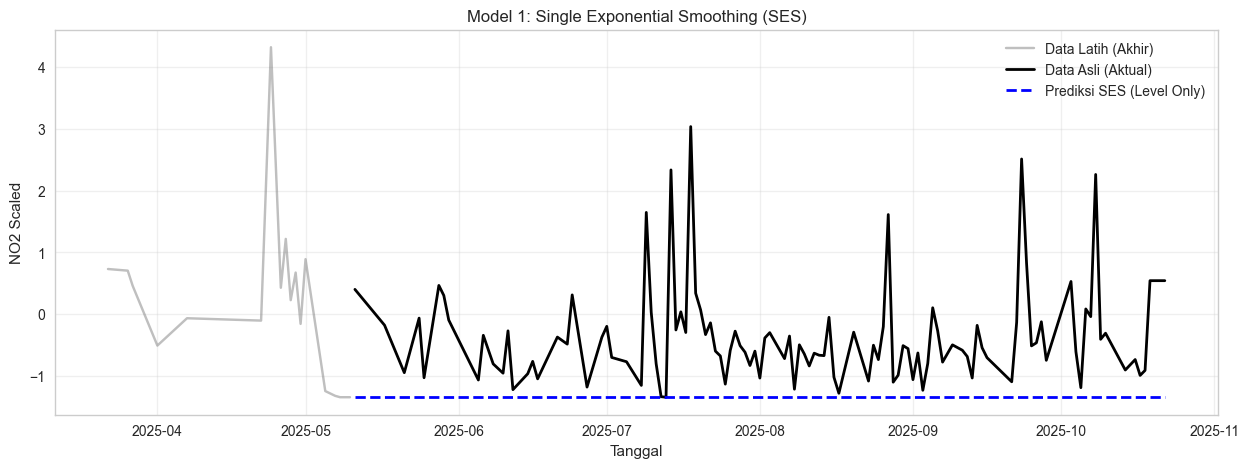

In [61]:
# ==========================================
# GRAFIK 1: Single Exponential Smoothing (SES)
# ==========================================
plt.figure(figsize=(15, 5))

# Plot Data Latih (Akhir) untuk konteks
plt.plot(train.index[-50:], train_data[-50:], label='Data Latih (Akhir)', color='gray', alpha=0.5)

# Plot Data Asli (Test)
plt.plot(test.index, test_data, label='Data Asli (Aktual)', color='black', linewidth=2)

# Plot Prediksi SES
plt.plot(test.index, pred_ses, label='Prediksi SES (Level Only)', color='blue', linestyle='--', linewidth=2)

plt.title('Model 1: Single Exponential Smoothing (SES)')
plt.legend()
plt.xlabel('Tanggal')
plt.ylabel('NO2 Scaled')
plt.grid(True, alpha=0.3)
plt.show()

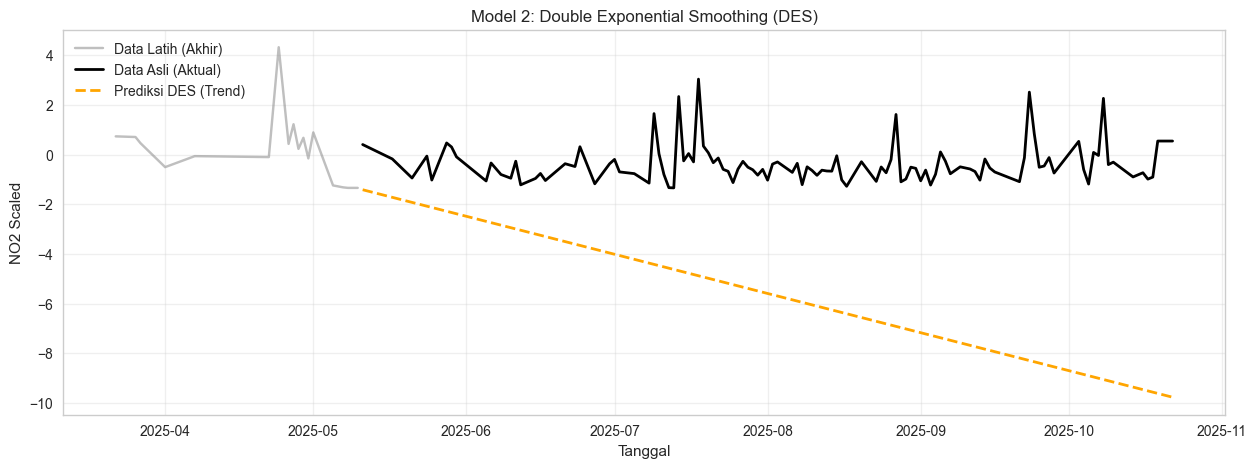

In [62]:
# ==========================================
# GRAFIK 2: Double Exponential Smoothing (DES)
# ==========================================
plt.figure(figsize=(15, 5))

# Plot Data Latih (Akhir)
plt.plot(train.index[-50:], train_data[-50:], label='Data Latih (Akhir)', color='gray', alpha=0.5)

# Plot Data Asli (Test)
plt.plot(test.index, test_data, label='Data Asli (Aktual)', color='black', linewidth=2)

# Plot Prediksi DES
plt.plot(test.index, pred_des, label='Prediksi DES (Trend)', color='orange', linestyle='--', linewidth=2)

plt.title('Model 2: Double Exponential Smoothing (DES)')
plt.legend()
plt.xlabel('Tanggal')
plt.ylabel('NO2 Scaled')
plt.grid(True, alpha=0.3)
plt.show()

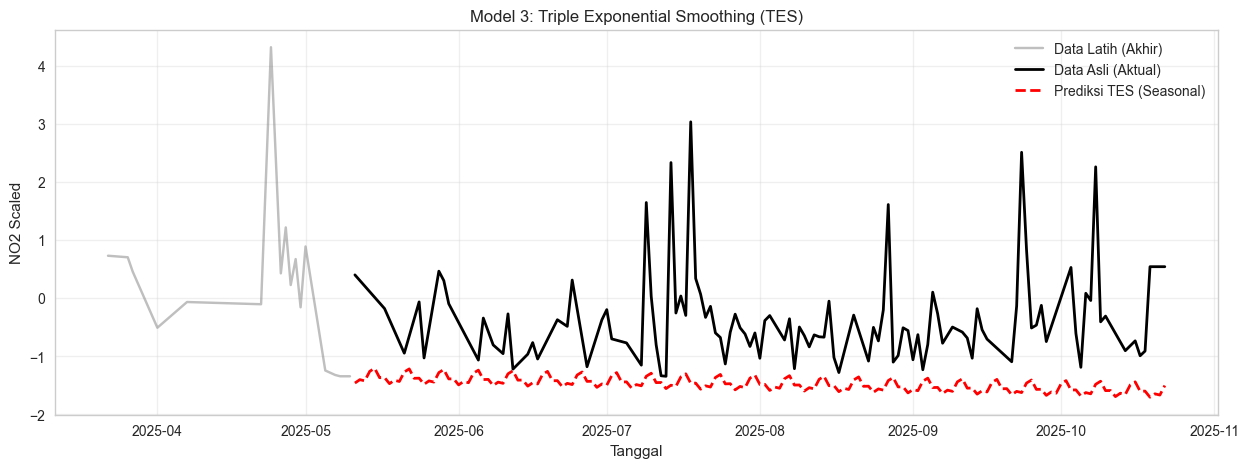

In [63]:
# ==========================================
# GRAFIK 3: Triple Exponential Smoothing (TES)
# ==========================================
plt.figure(figsize=(15, 5))

# Plot Data Latih (Akhir)
plt.plot(train.index[-50:], train_data[-50:], label='Data Latih (Akhir)', color='gray', alpha=0.5)

# Plot Data Asli (Test)
plt.plot(test.index, test_data, label='Data Asli (Aktual)', color='black', linewidth=2)

# Plot Prediksi TES
plt.plot(test.index, pred_tes, label='Prediksi TES (Seasonal)', color='red', linestyle='--', linewidth=2)

plt.title('Model 3: Triple Exponential Smoothing (TES)')
plt.legend()
plt.xlabel('Tanggal')
plt.ylabel('NO2 Scaled')
plt.grid(True, alpha=0.3)
plt.show()

#### 6. Prediksi NO2

Prediksi 5 Hari Pertama (Sekarang angkanya pasti beda-beda):
              Tanggal  Prediksi_NO2
2025-10-23 2025-10-23      0.555997
2025-10-24 2025-10-24      0.433375
2025-10-25 2025-10-25      0.413268
2025-10-26 2025-10-26      0.330502
2025-10-27 2025-10-27      0.409593


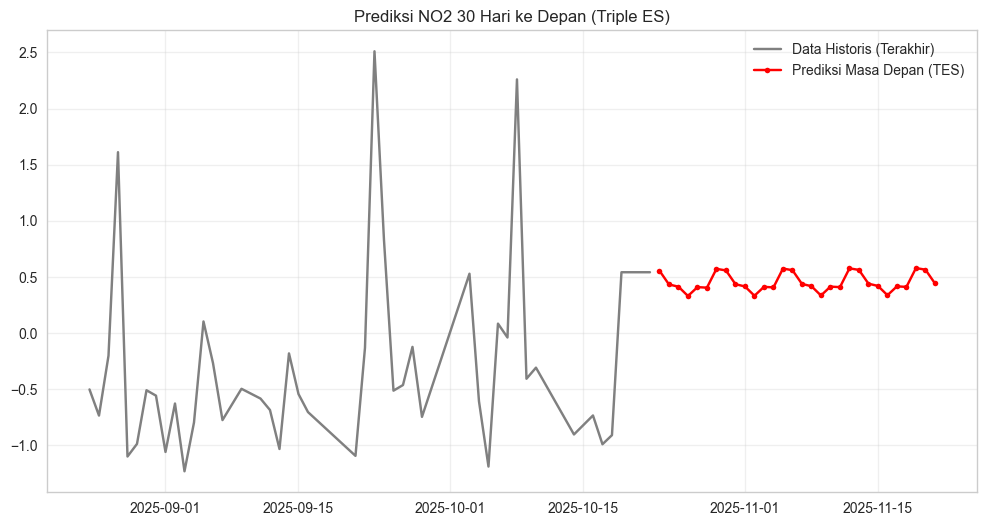

In [ ]:
full_model = ExponentialSmoothing(
    df['NO2_scaled'], 
    trend='add', 
    seasonal='add', 
    seasonal_periods=7  # Pola mingguan
).fit()

# Prediksi 30 hari ke depan
forecast_days = 30
future_forecast = full_model.forecast(forecast_days)

# Buat DataFrame
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=forecast_days)
df_future = pd.DataFrame({'Tanggal': future_dates, 'Prediksi_NO2': future_forecast})

print("Prediksi 5 Hari Pertama (Sekarang angkanya pasti beda-beda):")
print(df_future.head())

# Visualisasi Hasil Prediksi Masa Depan
plt.figure(figsize=(12, 6))
plt.plot(df.index[-60:], df['NO2_scaled'][-60:], label='Data Historis (Terakhir)', color='gray')
plt.plot(df_future['Tanggal'], df_future['Prediksi_NO2'], label='Prediksi Masa Depan (TES)', color='red', marker='o', markersize=4)
plt.title('Prediksi NO2 30 Hari ke Depan (Triple ES)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()